# Project Notebook - Machine Learning I

### Libraries

In [1]:
import pandas as pd
import numpy as np
import openml
from AdaBoostWorkyWorky import AdaBoost
from sklearn.model_selection import KFold, train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import scipy.stats as ss
import matplotlib.pyplot as plt


### Get the datasets to use throughout the project

Function to read a dataset from [OpenML-CC18 Curated Classification benchmark](https://www.openml.org/search?type=study&sort=tasks_included&study_type=task&id=99) givent its Task ID and return the corresponding Pandas Dataframe

In [2]:
def getDataset(task_id):
    suite = openml.study.get_suite(99)
    task = openml.tasks.get_task(task_id)    
    dataset = openml.datasets.get_dataset(task.dataset_id)

    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="array", target=dataset.default_target_attribute
    )

    df = pd.DataFrame(X, columns=attribute_names)
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1 
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)

    return df

Description of the datasets used in this project:
- A
- B
- C

In [3]:
datasets = [
    ("Task ID = 15", getDataset(15)),
    ("Task ID = 24", getDataset(24)),
    ("Task ID = 3904", getDataset(3904)),
    ("Task ID = 146820", getDataset(146820))
]

### Performance evaluation of AdaBoost

In [11]:
# function to perform cross validation on a set of algorithms ("algs")
def run_cv(X,y,algs,nfolds=10):
    results = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        results[algo_name] = []
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train, M=40)
            y_pred = algo.predict(X_test)
            results[algo_name].append(accuracy_score(y_test, y_pred))
    results_df = pd.DataFrame.from_dict(results)
    return results_df

In [12]:
# running 10-fold cross validation for all datasets and checking accuracy

for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    algs = [("AdaBoost", AdaBoost(duplicate=True))]
    result = run_cv(X, y, algs)
    print(f"Mean accuracy for dataset with {ds_id} in 10-fold CV: {np.mean(result['AdaBoost']):.5f}")


#Mean accuracy for dataset with Task ID = 15 in 10-fold CV: 0.96194
#Mean accuracy for dataset with Task ID = 24 in 10-fold CV: 0.87545
#Mean accuracy for dataset with Task ID = 3904 in 10-fold CV: 0.80974
#Mean accuracy for dataset with Task ID = 146820 in 10-fold CV: 0.94606

Mean accuracy for dataset with Task ID = 15 in 10-fold CV: 0.96483
Mean accuracy for dataset with Task ID = 24 in 10-fold CV: 0.92541
Mean accuracy for dataset with Task ID = 3904 in 10-fold CV: 0.71066
Mean accuracy for dataset with Task ID = 146820 in 10-fold CV: 0.96074


In [8]:
# function to plot the Confusion Matrix of a fitted model
def plot_cm(model_fit,X_test,y_test):
    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

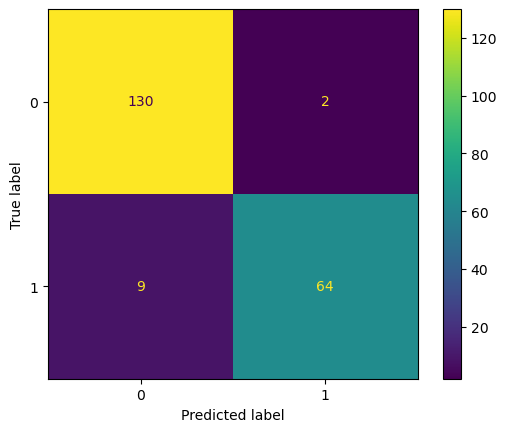

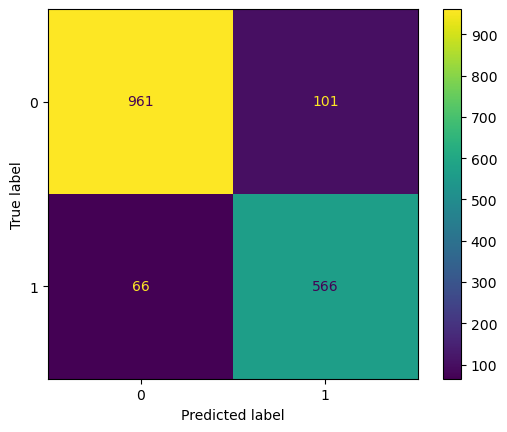

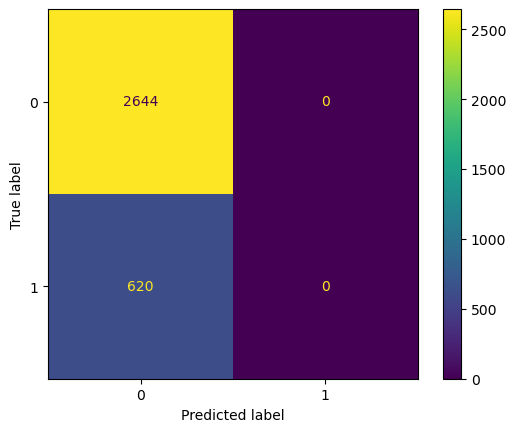

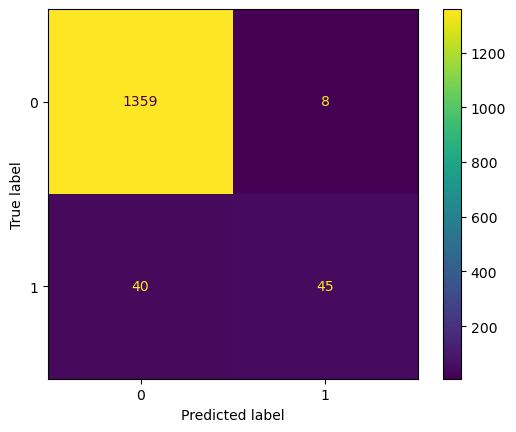

In [9]:
# confusion matrix for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ab = AdaBoost()
    ab.fit(X_train, y_train)
    plot_cm(ab, X_test, y_test)


In [ ]:
# function to plot the Learning Curve of a fitted model
def plot_learning_curves(model, X, y, title=''):
    training_size = np.linspace(0.1,0.9,10)

    train_scores = {}
    test_scores = {}
    for tr_size in training_size:
        train_scores[tr_size] = []
        test_scores[tr_size] = []
        # run 10 tests with training size = tr_size and store all accuracy results in a line of train_scores and test_scores
        for _ in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size)
            model.fit(X_train, y_train)
            training_pred = model.predict(X_train)
            testing_pred = model.predict(X_test)
            train_scores[tr_size].append(accuracy_score(training_pred, y_train))
            test_scores[tr_size].append(accuracy_score(testing_pred, y_test))
        # print some statistics
        print(
            f"Train size: {tr_size}\n \
            Mean training score: {round(np.mean(train_scores[tr_size]), 5)}\n \
            Standard deviation: {round(np.std(train_scores[tr_size]), 5)}"
        )

    train_mean = np.array([np.mean(train_scores[tr_size]) for tr_size in training_size])
    train_std = np.array([np.std(train_scores[tr_size]) for tr_size in training_size])
    test_mean = np.array([np.mean(test_scores[tr_size]) for tr_size in training_size])
    test_std = np.array([np.std(test_scores[tr_size]) for tr_size in training_size])

    plt.figure(figsize=(8, 6))
    plt.plot(training_size, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(training_size, test_mean, 'o-', color='green', label='Test score')
    plt.fill_between(training_size, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(training_size, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title('Learning Curves '+title)
    plt.show()


In [ ]:
# Learning Cruve for each dataset
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']

    ab = AdaBoost()
    plot_learning_curves(ab, X, y, title="AdaBoost")

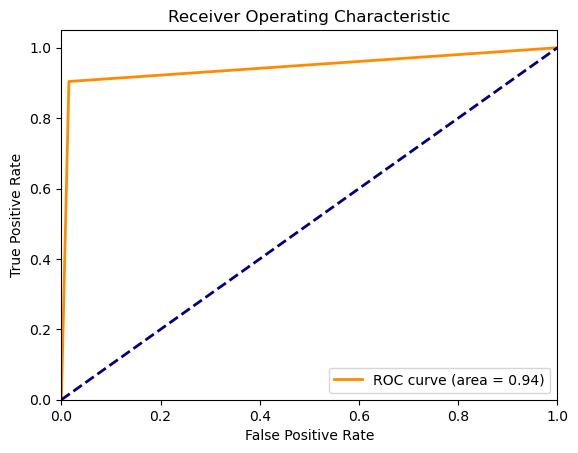

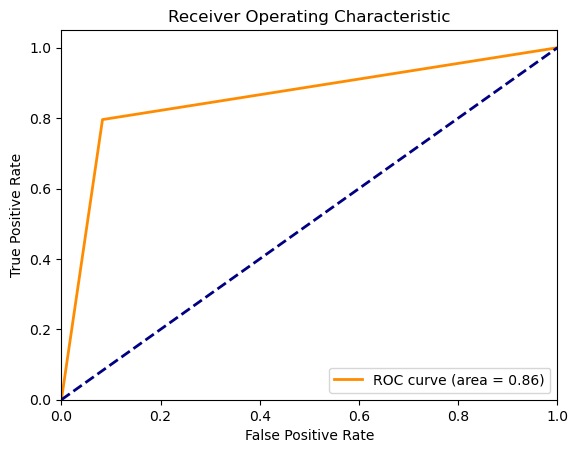

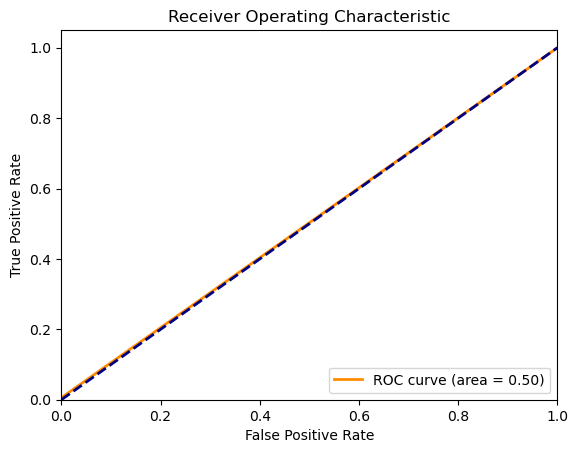

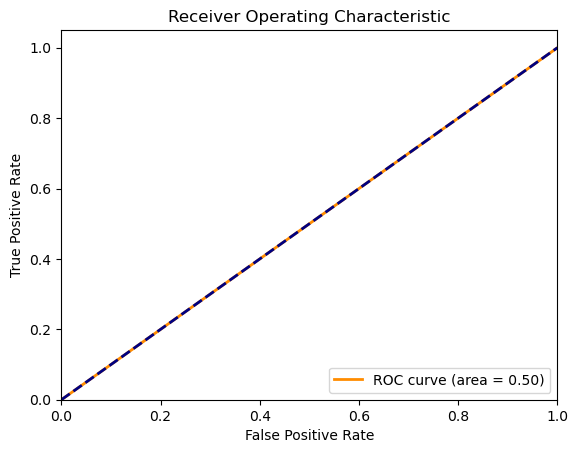

In [7]:
# functions to get ROC Curve and AUC score

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

"""
def auc(fpr, tpr):
    # Calculate the area under the ROC curve using the trapezoidal rule
    return np.trapz(tpr, fpr)

def roc_curve(y_true, y_pred):
    # Sort the true labels and predicted scores in descending order
    sorted_indices = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # Initialize variables
    tpr = [0.0]
    fpr = [0.0]
    threshold = [y_pred_sorted[0]]

    # Calculate true positive rate (TPR) and false positive rate (FPR)
    for i in range(1, len(y_pred_sorted)):
        if y_pred_sorted[i] != y_pred_sorted[i - 1]:
            tpr.append(tpr[-1])
            fpr.append(fpr[-1] + 1.0 / len(y_true))
            threshold.append(y_pred_sorted[i])
        else:
            tpr.append(tpr[-1] + 1.0 / sum(y_true_sorted))
            fpr.append(fpr[-1])

    tpr.append(1.0)
    fpr.append(1.0)

    return np.array(fpr), np.array(tpr), np.array(threshold)
"""

# Example usage:
# Assuming you have X_test and y_test as your test dataset
for ds_id, ds in datasets:
    ada_boost = AdaBoost()  # Instantiate your AdaBoost classifier
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    ada_boost.fit(X_train, y_train)  # Fit the classifier to your training data
    y_pred = ada_boost.predict(X_test)  # Get the binary predictions for the test data
    plot_roc_curve(y_test, y_pred)  # Plot the ROC curve


### Comparision of base algorithm and modified ones

In [ ]:
# define the models
models = [
    ("default", AdaBoost()),
    ("Alpha Changed", AdaBoost(alpha_type=1)),
    ("Duplicate Misclassified", AdaBoost(duplicate=True)),
    ("Alpha Changed & Duplicate Misclassified", AdaBoost(alpha_type=1, duplicate=True))
]

In [ ]:
# function to plot the results from 
def plot_cv(results_cv,metric='Accuracy', title="Cross-validation results for multiple algorithms in a single task"):
    fig, ax = plt.subplots()
    ax.boxplot(results_cv)
    ax.set_xticklabels(results_cv.columns)
    ax.set_ylabel(metric)
    ax.set_title(title)
    plt.show()

In [ ]:
# run 10-fold cross-validation on all algorithms and plot estimates
for ds_id, ds in datasets:
    X = ds.drop(columns=['target'], axis=1)
    y = ds['target']
    results = run_cv(X, y, models)
    plot_cv(results, title=f"Cross-validation for the algorithms in the dataset with {ds_id}")
    

In [ ]:
# to experiment the new adaboost

for i in range(4):
    print()
    print(i)
    X = datasets[i][1].drop(columns=['target'], axis=1)
    y = datasets[i][1]['target']
    print("Tamanho =", len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for alg_name, alg in models:
        alg.fit(X_train, y_train)
        y_pred = alg.predict(X_test)
        print(y_pred.value_counts())


In [ ]:
def run_cv_per_dataset():